In [ ]:
# ---- Setup ----
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pathlib import Path

# Find project root whether this notebook is in repo root or in notebook/
CWD = Path.cwd().resolve()
DATA_DIR = (CWD / "Data") if (CWD / "Data").exists() else (CWD.parent / "Data")

# Quick sanity check (optional)
print("Data dir:", DATA_DIR)
print("Files:", [p.name for p in DATA_DIR.glob("*")])

# Load dataset (replace filename if different)
df = pd.read_csv(DATA_DIR / "uplift_marketing_dataset.csv")
df.head()

Data dir: /Users/teo/Desktop/recommend-ad/Data
Files: ['webtoon.csv', '.DS_Store', 'ecommerce_2years_data.csv', 'uplift_marketing_dataset.csv', 'sabermetrics_2024.csv', 'top_insta_influencers_data.csv', 'BankChurners.csv']


,customer_id,age,gender,visit_count,avg_purchase_amount,prior_purchase,treatment,clicked,purchased
0,1,56,Male,5,101.06,0,1,0,1
1,2,69,Male,6,85.37,0,1,0,0
2,3,46,Male,5,69.29,1,0,0,0
3,4,32,Female,4,106.81,0,1,0,1
4,5,60,Male,6,86.13,1,1,1,0


## 1. Problem Statement

How can we measure the *true* effect of an advertisement?

A long-standing marketing question:  
*"This customer purchased after seeing the ad!"*  
→ Was this purchase actually driven by the ad, or would they have bought it anyway?


### Limitations of Traditional Approaches
- Wasted budget on mistargeted audiences
- Focusing only on loyal customers, missing persuadable prospects

| Traditional Approach | Limitation |
|----------------------|------------|
| Higher conversion rate after ad exposure | May include customers who would purchase without the ad |
| Simple A/B testing | Compares averages, making personalized targeting difficult |


### New Approach: Uplift Modeling
- Measures whether the ad **actually changed customer behavior**
- Segments customers into four groups:

| Group | Meaning |
|-------|---------|
| **Persuadable** | Customers who converted *because* of the ad |
| **Sure Thing** | Customers who would convert without the ad |
| **Lost Cause** | Customers who will not convert regardless of the ad |
| **Do Not Disturb** | Customers who are less likely to convert after seeing the ad |



### Key Question
*"Among customers who saw the ad, who truly responded to it?"*  
→ Can we identify these customers and allocate budget more efficiently?


### Data Summary
- Campaign dataset with **treatment** (ad exposure) and **control** (no exposure) groups
- Customer attributes + conversion outcomes
- Goal: Estimate uplift scores for each customer to enable **strategic targeting**

---

---

## 2. Analysis Objective
- **Goal:** Identify customers whose behavior changed due to the ad (*Persuadables*).
- Focus on the difference in behavior (Difference in Differences) rather than just absolute effects.

### What is Uplift Modeling?
> "Given whether a customer has seen the ad or not, predict the change in an individual's behavior."

### Traditional Prediction Models vs. Uplift Models

| Model Type             | Prediction Target                       | Goal                                                        | Application                          |
|------------------------|-----------------------------------------|-------------------------------------------------------------|---------------------------------------|
| Traditional Prediction | Conversion status                       | Find customers likely to convert                           | Broad targeting                      |
| Uplift Model           | Difference in behavior (exposed vs not) | Find customers whose conversion is influenced by the ad    | Strategic targeting to maximize ROI  |

### Planned Analysis Process

1. **Data Preparation**
   - Ad exposure (`treatment`)
   - Conversion status (`conversion`)
   - Customer attributes (`age`, `income`, etc.)

2. **EDA & Conversion Analysis**
   - Compare overall vs. group-level conversion rates

3. **Uplift Modeling**
   - Model types: Two-Model Approach (T-Learner), Uplift Trees, etc.

4. **Performance Evaluation & Strategic Segmentation**
   - Customer grouping (Persuadable, Sure Thing, etc.)
   - ROI simulation for actual campaign targeting
---

---

## 3. Data EDA and Insight Extraction

### Data Structure
- **treatment**: Ad exposure (1 = exposed, 0 = not exposed)  
- **purchased**: Final purchase outcome (1 = purchased, 0 = not purchased)  

### Basic Analysis
- What is the conversion rate of the exposed group (`treatment=1`)?  
- What is the conversion rate of the non-exposed group (`treatment=0`)?  
- Is there a significant difference in conversion rates between the two groups?  

### Analysis Objective
- Confirm the **average effect of advertising** by comparing conversion rates.  
- Extend the analysis to customer-level differences (**uplift effect**).  

### Next Step
- Load the dataset and verify its structure.


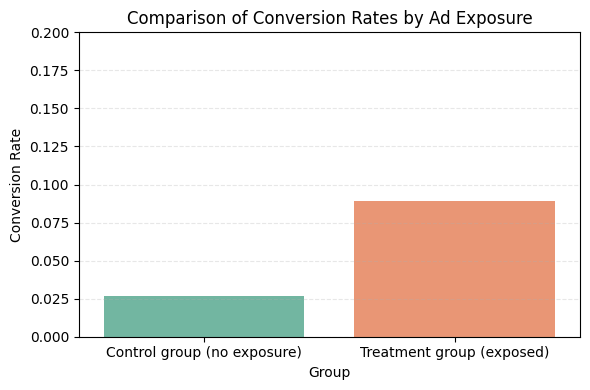

,treatment,conversion_rate
0,0,0.026997
1,1,0.089440


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate conversion rate by ad exposure
conversion_rate = df.groupby('treatment')['purchased'].mean().reset_index()
conversion_rate.columns = ['treatment', 'conversion_rate']

# Visualization
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_rate, x='treatment', y='conversion_rate', palette='Set2')
plt.xticks([0, 1], ['Control group (no exposure)', 'Treatment group (exposed)'])
plt.title('Comparison of Conversion Rates by Ad Exposure')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

conversion_rate

---

## Insight

- The conversion rate of the exposed group is more than **three times higher** compared to the non-exposed group.  
- This shows a positive effect of the ad campaign, but not all of the difference may be attributable to the ad itself (e.g., some customers might have already intended to purchase).

In [5]:
# Check the distribution of selected columns (gender, age, visit count, ad exposure, purchase)
df[['age', 'gender', 'visit_count', 'treatment', 'purchased']].describe(include='all')

,age,gender,visit_count,treatment,purchased
count,20000.000000,20000,20000.000000,20000.000000,20000.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,10003,NaN,NaN,NaN
mean,43.437700,NaN,5.000200,0.498100,0.058100
std,14.943908,NaN,2.242131,0.500009,0.233938
min,18.000000,NaN,0.000000,0.000000,0.000000
25%,31.000000,NaN,3.000000,0.000000,0.000000
50%,43.000000,NaN,5.000000,0.000000,0.000000
75%,56.000000,NaN,6.000000,1.000000,0.000000


- **Gender:** Two groups (Male, Female)  
- **Age:** 18–69 years (average ~43.4 years)  
- **Visit Count:** Average 5 visits, maximum 17 visits  

---

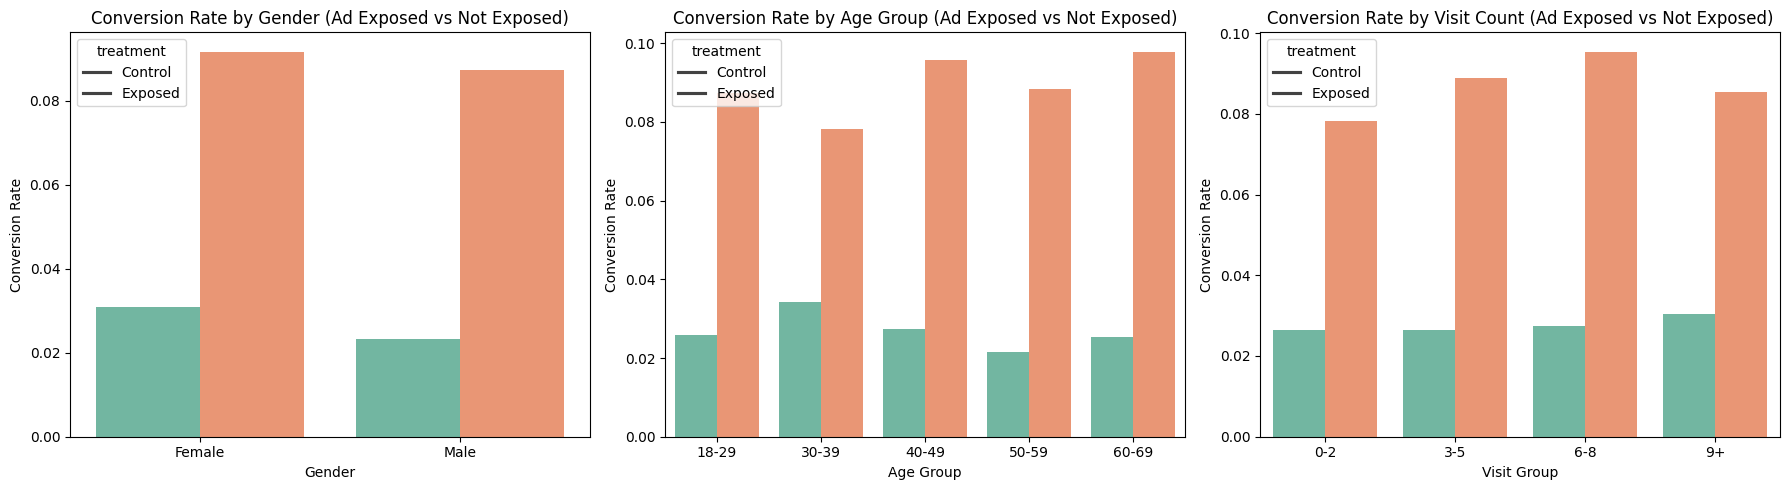

Gender conversion rates:
    treatment  gender  purchased
0          0  Female   0.030899
1          0    Male   0.023150
2          1  Female   0.091652
3          1    Male   0.087194
Age group conversion rates:
    treatment age_group  purchased
0          0     18-29   0.025911
1          0     30-39   0.034196
2          0     40-49   0.027490
3          0     50-59   0.021482
4          0     60-69   0.025468
5          1     18-29   0.087483
6          1     30-39   0.078173
7          1     40-49   0.095772
8          1     50-59   0.088421
9          1     60-69   0.097895
Visit count group conversion rates:
    treatment visit_group  purchased
0          0         0-2   0.026398
1          0         3-5   0.026462
2          0         6-8   0.027346
3          0          9+   0.030441
4          1         0-2   0.078268
5          1         3-5   0.088952
6          1         6-8   0.095421
7          1          9+   0.085434


In [7]:
# Gender × Ad exposure conversion rate
gender_conv = df.groupby(['treatment', 'gender'])['purchased'].mean().reset_index()

# Create age groups (10-year bins)
df['age_group'] = pd.cut(df['age'], bins=[17, 29, 39, 49, 59, 69],
                         labels=['18-29', '30-39', '40-49', '50-59', '60-69'])

# Age group × Ad exposure conversion rate
age_conv = df.groupby(['treatment', 'age_group'])['purchased'].mean().reset_index()

# Create visit count groups
df['visit_group'] = pd.cut(df['visit_count'], bins=[-1, 2, 5, 8, 20],
                           labels=['0-2', '3-5', '6-8', '9+'])

# Visit count × Ad exposure conversion rate
visit_conv = df.groupby(['treatment', 'visit_group'])['purchased'].mean().reset_index()


import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender
sns.barplot(data=gender_conv, x='gender', y='purchased',
            hue='treatment', ax=axes[0], palette='Set2')
axes[0].set_title('Conversion Rate by Gender (Ad Exposed vs Not Exposed)')
axes[0].set_ylabel('Conversion Rate')
axes[0].set_xlabel('Gender')
axes[0].legend(title='treatment', labels=['Control', 'Exposed'])

# Age group
sns.barplot(data=age_conv, x='age_group', y='purchased',
            hue='treatment', ax=axes[1], palette='Set2')
axes[1].set_title('Conversion Rate by Age Group (Ad Exposed vs Not Exposed)')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('Age Group')
axes[1].legend(title='treatment', labels=['Control', 'Exposed'])

# Visit count
sns.barplot(data=visit_conv, x='visit_group', y='purchased',
            hue='treatment', ax=axes[2], palette='Set2')
axes[2].set_title('Conversion Rate by Visit Count (Ad Exposed vs Not Exposed)')
axes[2].set_ylabel('Conversion Rate')
axes[2].set_xlabel('Visit Group')
axes[2].legend(title='treatment', labels=['Control', 'Exposed'])

plt.tight_layout()
plt.show()

print("Gender conversion rates:\n", gender_conv)
print("Age group conversion rates:\n", age_conv)
print("Visit count group conversion rates:\n", visit_conv)


## Insights

### Gender
- When exposed to ads, both male and female customers show higher conversion rates.  
- The effect of advertising appears stronger among female customers.  

### Age Group
- Without ad exposure, conversion rates are generally low and flat across age groups.  
- The effect of ad exposure is strongest among customers aged **30–39** and **40–49**.  

### Visit Count Group
- Conversion rates increase with the number of visits.  
- Customers with **3–5 visits** show the strongest ad effect, indicating a high potential for persuasion.  


---

--- 

## 4. Data Analysis and Modeling – Estimating Customer-Level Uplift Scores


### Objective
- Estimate the difference in conversion probability (Uplift) depending on ad exposure.  
- Measure whether the ad actually changed customer behavior, rather than just overall conversion probability.  
- Enable refined targeting to identify persuadable customers.  


### Model Choice
- **Base Model: Two-Model (T-Learner)**  
  - Train separate models for exposed vs. non-exposed groups.  
  - The difference between the predicted conversion probabilities = uplift score.  


### Variables for Training
- **Target:** `purchased`  
- **Features:** `age`, `gender`, `visit_count`, `avg_purchase_amount`, `prior_purchase`, …  

---

### Preparation
- Split data and set up training for uplift modeling.


In [8]:
# Preprocessing & Training Preparation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Select features and target
features = ['age', 'gender', 'visit_count', 'avg_purchase_amount', 'prior_purchase']
X = df[features]
y = df['purchased']
treatment = df['treatment']

# One-hot encode categorical variables (gender)
X = pd.get_dummies(X, drop_first=True)

# Split into treatment group
X_treat = X[treatment == 1]
y_treat = y[treatment == 1]

# Split into control group
X_ctrl = X[treatment == 0]
y_ctrl = y[treatment == 0]

In [9]:
# Train Two Separate Models (T-Learner)

# Initialize models for treatment and control groups
model_treat = RandomForestClassifier(random_state=42)
model_ctrl = RandomForestClassifier(random_state=42)

# Train each model separately
model_treat.fit(X_treat, y_treat)
model_ctrl.fit(X_ctrl, y_ctrl)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Uplift Score Calculation

# Predict conversion probability for all customers
proba_treat = model_treat.predict_proba(X)[:, 1]
proba_ctrl = model_ctrl.predict_proba(X)[:, 1]

# Store probabilities and uplift score in the dataframe
df['proba_treat'] = proba_treat   # P(conversion | exposed)
df['proba_ctrl'] = proba_ctrl     # P(conversion | not exposed)
df['uplift_score'] = proba_treat - proba_ctrl  # Uplift = difference

# Display top 10 customers with highest uplift scores
df[['customer_id', 'treatment', 'proba_treat', 'proba_ctrl', 'uplift_score']] \
    .sort_values(by='uplift_score', ascending=False) \
    .head(10)

,customer_id,treatment,proba_treat,proba_ctrl,uplift_score
15926,15927,1,0.87,0.00,0.87
2735,2736,1,0.85,0.00,0.85
14242,14243,1,0.84,0.00,0.84
16000,16001,1,0.86,0.03,0.83
14783,14784,1,0.82,0.00,0.82
12113,12114,1,0.82,0.00,0.82
16012,16013,1,0.83,0.01,0.82
16746,16747,1,0.85,0.03,0.82
1584,1585,1,0.94,0.12,0.82
18790,18791,1,0.81,0.00,0.81


- **Uplift Score > 0:** Higher likelihood of conversion when exposed to ads → Candidate for targeting  
- **Uplift Score < 0:** Lower likelihood of conversion when exposed to ads → Candidate for *Do Not Disturb*  

---

---
## 5. Model Evaluation – Validating Uplift Model Performance and ROI Simulation

### Evaluation Objectives
- Assess whether the uplift model effectively identifies **Persuadable customers**.  
- Analyze the impact of targeting strategies based on predicted uplift scores.  

### Key Evaluation Tools

| Metric                | Description |
|------------------------|-------------|
| **Qini Curve**         | Performance curve showing actual uplift achieved by the model |
| **Uplift Decile Analysis** | Compare conversion rates across customer segments sorted by uplift scores |
| **ROI Simulation**     | Simulate profit/cost impact under different targeting scenarios |


In [13]:
# Uplift Decile Segmentation and Analysis

# Create uplift deciles (Top 10 groups based on uplift score)
df['uplift_decile'] = pd.qcut(df['uplift_score'], 10, labels=False, duplicates='drop')

# Calculate purchase conversion for each decile
decile_df = df.groupby('uplift_decile')['purchased'].agg(['count', 'sum'])
decile_df['conversion_rate'] = decile_df['sum'] / decile_df['count']

# Sort by decile in descending order (to see higher uplift groups first)
decile_df = decile_df.sort_index(ascending=False)

# Display decile summary (count, sum of purchases, and conversion rate)
decile_df[['count', 'sum', 'conversion_rate']].reset_index()

,uplift_decile,count,sum,conversion_rate
0,8,1918,889,0.463504
1,7,1901,2,0.001052
2,6,1694,0,0.000000
3,5,2234,0,0.000000
4,4,1205,0,0.000000
5,3,2953,0,0.000000
6,2,1960,0,0.000000
7,1,4021,0,0.000000
8,0,2114,271,0.128193


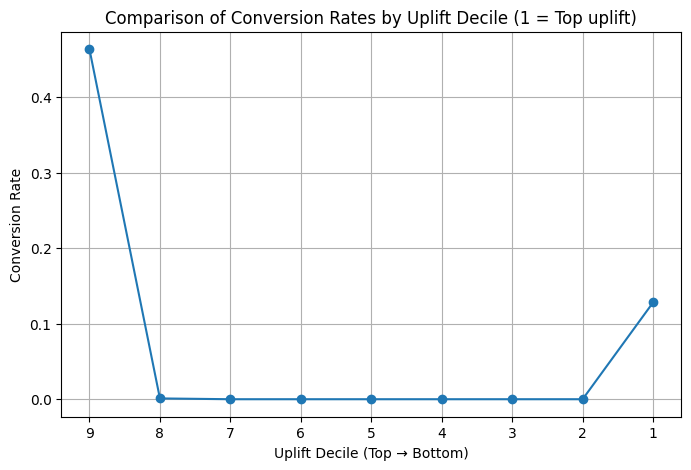

,conversion_rate
uplift_decile,
8,0.463504
7,0.001052
6,0.000000
5,0.000000
4,0.000000
3,0.000000
2,0.000000
1,0.000000
0,0.128193


In [14]:
# Calculate conversion rate per decile and visualize

# Aggregate purchase counts and sums by uplift decile
decile_df = df.groupby('uplift_decile')['purchased'].agg(['count', 'sum'])
decile_df['conversion_rate'] = decile_df['sum'] / decile_df['count']

# Sort by decile index (descending for top uplift groups first)
decile_df = decile_df.sort_index(ascending=False)

import matplotlib.pyplot as plt

# Plot conversion rate by uplift decile
plt.figure(figsize=(8, 5))
plt.plot(decile_df.index + 1, decile_df['conversion_rate'], marker='o')
plt.gca().invert_xaxis()  # Show top uplift (1) on the left
plt.title('Comparison of Conversion Rates by Uplift Decile (1 = Top uplift)')
plt.xlabel('Uplift Decile (Top → Bottom)')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.show()

# Display conversion rate table
decile_df[['conversion_rate']]

### Uplift Decile Analysis Summary

- **Uplift Decile Conversion Rates**
  - **Top (Decile 9):** 46.3%
  - **Bottom (Decile 0):** 12.9%
  - Most other deciles: close to 0% or very low

### Insights
- In the **top decile (Top 10%)**, conversion rates are very high → these customers are likely **Persuadables**, meaning they would not have converted without exposure to the ad.  
- In the **bottom decile**, conversion rates are close to 0% → these customers are likely **unresponsive** to advertising or even potential **Do-Not-Disturb** candidates.

---

---
## 6. Action Items and Strategy: Uplift-Based Automated Targeting

### Final Goals
- Use uplift scores to **focus marketing resources on high-efficiency customers**  
- Design strategies centered on customers whose behavior change is **truly driven by ads (Persuadables)**  

### Customer Segmentation Strategy

| Customer Group   | Definition                                | Targeting Strategy   |
|------------------|--------------------------------------------|----------------------|
| **Persuadable**  | Customers who convert **because of the ad** | **Highest priority targeting** |
| **Sure Thing**   | Customers who convert **without ads**      | Ads unnecessary |
| **Lost Cause**   | Customers who will **not convert** under any condition | Exclude |
| **Do Not Disturb** | Customers less likely to convert after seeing ads | **Avoid targeting** |

In [15]:
# Example: Classifying customer groups based on uplift decile conversion rates
# High conversion (Decile = 8) → Persuadable
# Mid-range (Decile = 0) → Sure Thing
# Very low conversion → Lost Cause or Do Not Disturb

def classify_group_by_conversion(decile):
    if decile == 8:
        return 'Persuadable'
    elif decile == 0:
        return 'Sure Thing'
    else:
        return 'Lost Cause'

# Assign group labels based on uplift decile
df['uplift_group'] = df['uplift_decile'].apply(classify_group_by_conversion)

# Check distribution of classified groups
df['uplift_group'].value_counts()

uplift_group
Lost Cause     15968
Sure Thing      2114
Persuadable     1918
Name: count, dtype: int64

## Decile-based Insights and Targeting Strategy

### Decile 8
- Conversion rate is **46.25% (very high)**
- Strongly responsive to advertising → **Core Persuadable group**
- Explosive uplift in conversions due to ad exposure
- Should receive **highest marketing budget priority**

### Decile 0
- Conversion rate is **12.85% (moderately high)**
- Low uplift_decile → likely **Sure Thing**
- Customers would purchase even without advertising
- Represents a **non-cost-effective target** for ads

### Decile 7~1
- Conversion rate is nearly **0%**
- Customers show **no meaningful response** to ads
- Classified as **Lost Cause** (hard-to-convert group)

---

### Summary Table

| Decile | Conversion | Model Judgment     | Practical Strategy                  |
|--------|------------|-------------------|-------------------------------------|
| 8      | High       | Persuadable       | 🎯 Focused targeting                 |
| 0      | Moderate   | Sure Thing        | 📉 Ads/remarketing not necessary     |
| 1~7    | Low        | Lost Cause        | ❌ Avoid → high risk of wasted budget |
